# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
## methods 

generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s
mainstream = [1, 3, 5, 8, 10, 12, 14]

#generation
def classify_gen(value):
    '''rescaling generation
    input: generation map
            dataframe value
    output:dataframe column value
    '''
    try:
        for key, values in generations.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan

# Movement 

def classify_mov(value):
    '''rescaling movement
    input: movement map
            dataframe value
    output:dataframe column value
    '''
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    # In case value is NaN
    except ValueError:
        return np.nan

def create_plot(col,df1,df2):
    '''ploting two subsets of missing values
    input: column name 
            dataframe missing values less than 30
            dataframe missing values more than 30
    output:dataframe column value
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    ax1.set_title('missing values less than 30')

    sns.countplot(df1[col],ax=ax1)

    ax2.set_title('missing values above 30')

    sns.countplot(df2[col],ax=ax2)
    plt.show()

# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#German CAMEO: Wealth / Life Stage Typology, mapped to international code
def classify_weal(value):
    '''map wealth
    input: column value 
           
    output: column value transformed
    '''
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return first digit
        return int(str(value)[0])

def classify_life(value):
    '''map life
    input: column value 
           
    output: column value transformed
    '''
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return second digit
        return int(str(value)[1])


def scene_plot(pca_, components_no=None, show_labels=False):
    ''''
    plot the curve with the explain process of features
    input: pca, numbers of components, flag to show labels
    output: graphic curve with the explain process of features
    '''
    vals = pca_.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

def pca_weights(df, pca, component_no, features_no, show_plot=True):
    
    ''' Build a dataframe with features_no features capturing most variability
    for a given component number (component_no)
    input: DATAFRAME, pca, number of components, number of features, flag to show the graphic
    output: graphic of features capturing most variability
    '''
    pca_comp = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys()).iloc[component_no - 1]
    pca_comp.sort_values(ascending=False, inplace=True)
    pca_comp = pd.concat([pca_comp.head(features_no), pca_comp.tail(features_no)])
    
    if show_plot:
        # Plot the result
        pca_comp.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(features_no*2, component_no),
                  figsize=(6, 6))
        plt.show()
    print(pca_comp)
    
    return pca_comp

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",delimiter=';')

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('rows:',len(azdias))
print('columns:',len(azdias.columns))


rows: 891221
columns: 85


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
print('rows:',len(feat_info))
print('columns:',len(feat_info.columns))

rows: 85
columns: 4


In [8]:
np.sum(azdias[azdias.columns[0]]==-1)+np.sum(azdias[azdias.columns[0]]==0)



685843

In [9]:
np.sum(azdias[azdias.columns[1]]==0)+np.sum(azdias[azdias.columns[1]]==9)+np.sum(azdias[azdias.columns[1]]==-1)

2881

In [10]:
np.sum(azdias[azdias.columns[2]]==0)+np.sum(azdias[azdias.columns[2]]==-1)

0

In [11]:
np.sum(azdias[azdias.columns[2]].isnull())

0

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
#searching for missing value and unknown and replace by nan
i=0
for col in azdias.columns:
    #azdias['azdias[azdias.columns[i]]==''']=np.nan
    indicator = feat_info['missing_or_unknown'][i].replace('[','').replace(']','').split(',')

    for ind in indicator:


        if ind!='':
            try:
                azdias[col].replace(int(ind),np.NaN,inplace=True)
             
            except ValueError as e:
                
                azdias[col].replace(ind,np.NaN,inplace=True)
    i=i+1
                

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [13]:
df_azdias_missing = np.sum(azdias.isnull()).reset_index()
df_azdias_missing.describe()

,0
count,85.000000
mean,98516.811765
std,146604.203317
min,0.000000
25%,0.000000
50%,93148.000000
75%,116515.000000
max,889061.000000


In [14]:
# 75% - 116515.000000
df_azdias_missing = df_azdias_missing[df_azdias_missing[0]>116515]
df_azdias_missing.sort_values(by=0,ascending=True,inplace=True)

In [15]:
df_azdias_missing

,index,0
60,KBA05_ANTG1,133324
61,KBA05_ANTG2,133324
62,KBA05_ANTG3,133324
63,KBA05_ANTG4,133324
65,KBA05_GBZ,133324
71,MOBI_REGIO,133324
48,W_KEIT_KIND_HH,147988
70,KKK,158064
73,REGIOTYP,158064
43,ALTER_HH,310267


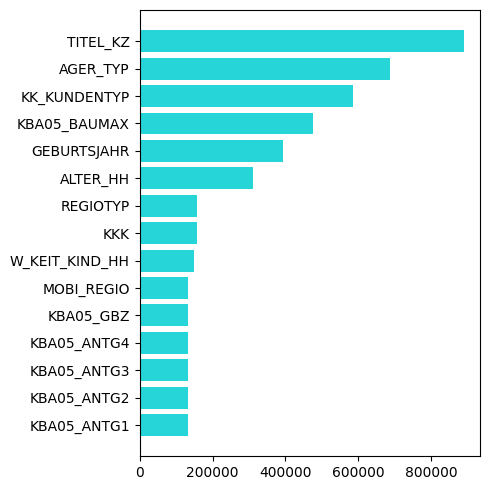

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.figure(figsize=(5,5))
barh = plt.barh(df_azdias_missing['index'],df_azdias_missing[0],color = 'darkturquoise', alpha = 0.85)
plt.tight_layout()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_name = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']
azdias.drop(labels=columns_name,axis=1,inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Are there any patterns in missing values? Which columns were removed from the dataset?

#### Answer: 

6 columns that have more than 200,000 missing values

Removed columns: 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH'

The pattern is information that is not fitted for all customers

TITEL_KZ - Academic title flag. **No all customers have academic degree**

AGER_TYP - Best-ager typology - **This does not make sense for all customers**

KK_KUNDENTYP - Consumer pattern over past 12 months - **Not all customers return to buy**

KBA05_BAUMAX - Most common building type within the microcell - **Not provided the cause**

GEBURTSJAHR - Year of birth - **Maybe people dont want to share this info**

ALTER_HH - Birthdate of head of household -**Maybe people dont want to share this info or they dont know it**





#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
azdias.isnull().sum()


ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 79, dtype: int64

In [19]:
null_values=azdias.isnull().sum()
columns=null_values[null_values<18].index

top_few_missing_columns=columns[:5]

top_few_missing_columns




Index(['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER'],
      dtype='object')

In [20]:
azdias['num_null'] = azdias.isnull().sum(axis=1)


(array([6.97109e+05, 7.76340e+04, 1.28010e+04, 9.53300e+03, 8.29000e+02,
        1.55000e+02, 1.40160e+04, 5.03100e+03, 2.80380e+04, 4.60750e+04]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <BarContainer object of 10 artists>)

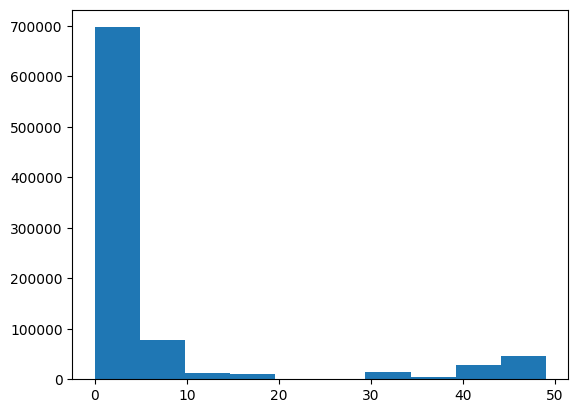

In [21]:
plt.hist(azdias['num_null'],bins=10)

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

print(azdias.shape)

df_azdias_under30 = azdias[azdias['num_null']<30]
df_azdias_more30  = azdias[azdias['num_null']>30]


(891221, 80)


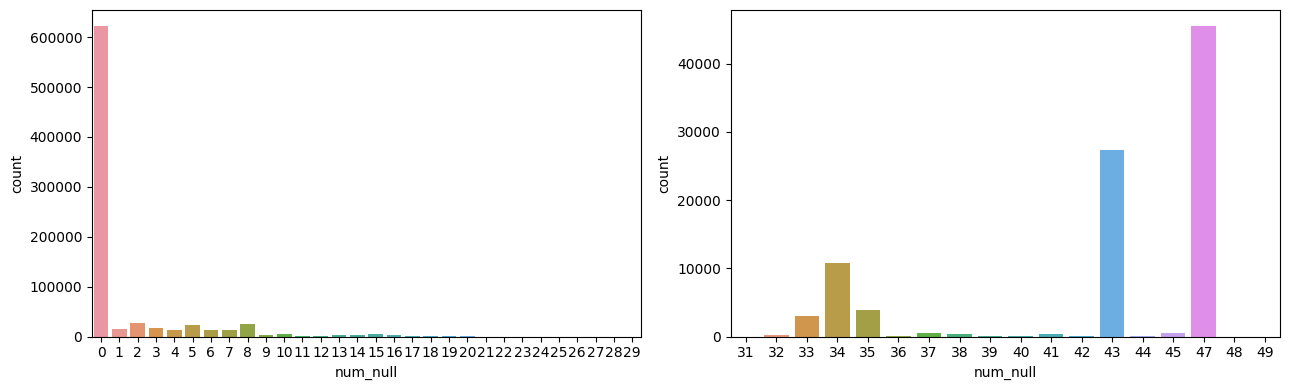

In [23]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,4))
sns.countplot(x='num_null',data=df_azdias_under30,ax=ax1,orient='v')
sns.countplot(x='num_null',data=df_azdias_more30,ax=ax2,orient='v')
plt.tight_layout()


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?

feat_info=feat_info[feat_info.attribute.isin(df_azdias_under30.columns)]

In [25]:


feat_info.type.value_counts()



type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [26]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features = feat_info[feat_info.type == 'categorical'].attribute

print(categorical_features)





2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [27]:

categorical_binary = []
categorical_multi = []
for feature in categorical_features:
    if azdias[feature].nunique() > 2:
        categorical_multi.append(feature)
    else:
        categorical_binary.append(feature)



In [28]:
for col in categorical_binary:
    print(azdias[col].value_counts())

ANREDE_KZ
2    465305
1    425916
Name: count, dtype: int64
GREEN_AVANTGARDE
0    715996
1    175225
Name: count, dtype: int64
SOHO_KZ
0.0    810834
1.0      6888
Name: count, dtype: int64
VERS_TYP
2.0    398722
1.0    381303
Name: count, dtype: int64
OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64


In [29]:
# Standardize binary columns into 0 or 1
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)



In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

for col in categorical_multi:
    print(azdias[col].value_counts())

CJT_GESAMTTYP
4.0    210963
3.0    156449
6.0    153915
2.0    148795
5.0    117376
1.0     98869
Name: count, dtype: int64
FINANZTYP
6    290367
1    199572
4    130625
2    110867
5    106436
3     53354
Name: count, dtype: int64
GFK_URLAUBERTYP
12.0    138545
5.0     120126
10.0    109127
8.0      88042
11.0     79740
4.0      63770
9.0      60614
3.0      56007
1.0      53600
2.0      46702
7.0      42956
6.0      27138
Name: count, dtype: int64
LP_FAMILIE_FEIN
1.0     426379
10.0    137913
2.0     104305
11.0     51719
8.0      23032
7.0      20730
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: count, dtype: int64
LP_FAMILIE_GROB
1.0    426379
5.0    200780
2.0    104305
4.0     52784
3.0     29181
Name: count, dtype: int64
LP_STATUS_FEIN
1.0     219275
9.0     143238
2.0     118236
10.0    118022
4.0      78317
5.0      74493
3.0      74105
6.0      30914
8.0      19708
7.0      10059
Name: count, dtype: int64
LP_STATUS_GROB
1.0    337511
2.0    

#### Discussion 1.2.1: Re-Encode Categorical Features

Which ones did you keep, which did you drop, and what engineering steps did you perform?

For binary data, I replaced 'VERS_TYP' 2.0 to 1 and  1.0 to 0

I replaced 'OST_WEST_KZ' 'W' to 1 

I replaced 'ANREDE_KZ' 2 to 1 and 1 to 0

One-hot encode columns of categorical feature and more other columns that is multi value and need to be transformed

['ORTSGR_KLS9','RELAT_AB','REGIOTYP','BALLRAUM','INNENSTADT', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4','ALTERSKATEGORIE_GROB']
   




In [31]:
# Do one-hot-encoding and remove reference columns
azdias = pd.get_dummies(azdias, columns=categorical_multi)


In [32]:
name_columns_ordinal = ['ORTSGR_KLS9','RELAT_AB','REGIOTYP','BALLRAUM','INNENSTADT', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4','ALTERSKATEGORIE_GROB']
   

In [33]:
for col in name_columns_ordinal:
    print(azdias[col].value_counts())

ORTSGR_KLS9
5.0    148096
4.0    114909
7.0    102866
9.0     91879
3.0     83542
6.0     75995
8.0     72709
2.0     63362
1.0     40589
Name: count, dtype: int64
RELAT_AB
3.0    274008
5.0    174964
1.0    142907
2.0    104846
4.0     97121
Name: count, dtype: int64
REGIOTYP
6.0    195286
5.0    145359
3.0     93929
2.0     91662
7.0     83943
4.0     68180
1.0     54798
Name: count, dtype: int64
BALLRAUM
6.0    255093
1.0    151782
2.0    104521
7.0     99039
3.0     73277
4.0     61358
5.0     52411
Name: count, dtype: int64
INNENSTADT
5.0    147626
4.0    134067
6.0    111679
2.0    109048
3.0     92818
8.0     82870
7.0     67463
1.0     51910
Name: count, dtype: int64


In [34]:
azdias = pd.get_dummies(azdias, columns=name_columns_ordinal)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

df_azdias_under30['PRAEGENDE_JUGENDJAHRE']
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)


1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
          ... 
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 798061, dtype: float64

In [36]:
# generation feature
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_gen)

# movement feature
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_mov)



In [37]:
# Engineer wealth column
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_weal)

# Engineer life stage column
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_life)


In [38]:
#removing not needed data
azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                      'CAMEO_INTL_2015'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Which ones did you keep, which did you drop, and what engineering steps did you perform?)


Answer: TOP - five columns with more missing values
#TOP 5 > 116515
['KKK','W_KEIT_KIND_HH','KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG3','KBA05_ANTG2',  'KBA05_ANTG1','KBA05_ANTG4' ]

I dropped the rest of mixed features to simplified the problem:['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']

I separated the information inside these two features creating new data and removed the root of the feature.
['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_azdias_missing2 = np.sum(azdias.isnull()).reset_index()
df_azdias_missing2.describe()

,0
count,228.000000
mean,17140.789474
std,40219.649771
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,158064.000000


In [40]:
df_azdias_missing2.sort_values(by=0,ascending=False,inplace=True)
df_azdias_missing2.head(10)

,index,0
47,KKK,158064
32,W_KEIT_KIND_HH,147988
44,KBA05_GBZ,133324
48,MOBI_REGIO,133324
42,KBA05_ANTG3,133324
41,KBA05_ANTG2,133324
40,KBA05_ANTG1,133324
43,KBA05_ANTG4,133324
54,PLZ8_ANTG4,116515
55,PLZ8_BAUMAX,116515


In [41]:
#TOP 5 > 116515
columns_to_drop = ['KKK','W_KEIT_KIND_HH','KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG3','KBA05_ANTG2',  'KBA05_ANTG1','KBA05_ANTG4' ]
azdias.drop(labels=columns_to_drop,axis=1,inplace=True)

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Remove unneeded and the rest of mixed columns (as per instruction above)
mixed_variables=feat_info[feat_info.type=="mixed"].attribute
mixed_variables

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [43]:
rest_mixed_variables =['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']

In [44]:
azdias.drop(labels=rest_mixed_variables,axis=1,inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df, df_feat):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:

    # ---------convert missing value codes into NaNs, ...

    #searching for missing value and unknown and replace by nan
    i=0
    for col in df.columns:
        
        indicator = df_feat['missing_or_unknown'][i].replace('[','').replace(']','').split(',')

        for ind in indicator:


            if ind!='':
                try:
                    df[col].replace(int(ind),np.NaN,inplace=True)
             
                except ValueError as e:
                
                    df[col].replace(ind,np.NaN,inplace=True)
        i=i+1
       
     # ---------convert missing value codes into NaNs, ...
    


    # # -----remove selected columns and rows, ...
    
    columns_name = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']

    df.drop(labels=columns_name,axis=1,inplace=True)
    print("0:",df.shape)
     # Drop the corresponding columns from feat_info
    df_feat = df_feat[~df_feat.attribute.isin(columns_name)]

    # In order to merge to dataframes by index we need to have indexes
    # as attributes in both dataframes
    df_feat.set_index('attribute', inplace=True, drop=False)
    
    # select, re-encode, and engineer column values.
    # Standardize binary columns into 0 or 1
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    
    
    
   
    # # -----remove selected columns and rows, ...


    # # ---------Do one-hot-encoding and remove reference columns
    categorical_features = df_feat[df_feat.type == 'categorical'].attribute
    categorical_binary = []
    categorical_multi = []
    for feature in categorical_features:
        if df[feature].nunique() > 2:
            categorical_multi.append(feature)
        else:
            categorical_binary.append(feature)
    
    df = pd.get_dummies(df, columns=categorical_multi)


    name_columns_ordinal = ['ORTSGR_KLS9','RELAT_AB','REGIOTYP','BALLRAUM','INNENSTADT', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4','ALTERSKATEGORIE_GROB']
    df = pd.get_dummies(df, columns=name_columns_ordinal)

    generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    
    # generation feature
    df['PRAEGENDE_JUGENDJAHRE_GEN'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_gen)

    # movement feature
    df['PRAEGENDE_JUGENDJAHRE_MOV'] = df['PRAEGENDE_JUGENDJAHRE'].apply(classify_mov)

    # Engineer wealth column
    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(classify_weal)

    # Engineer life stage column
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(classify_life)
    
    # ---------Do one-hot-encoding and remove reference columns

    #---------removing not needed data
    #removing not needed data
    df = df.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1)
    df_feat = df_feat[~df_feat.attribute.isin(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])]

    #TOP 5 > 116515
    columns_to_drop = ['KKK','W_KEIT_KIND_HH','KBA05_GBZ', 'MOBI_REGIO', 'KBA05_ANTG3','KBA05_ANTG2',  'KBA05_ANTG1','KBA05_ANTG4' ]
    df.drop(labels=columns_to_drop,axis=1,inplace=True)
    
    df_feat = df_feat[~df_feat.attribute.isin(columns_to_drop)]

    #mixed_variables=df_feat[df_feat.type=="mixed"].attribute
    rest_mixed_variables =['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX']
    df.drop(rest_mixed_variables, axis=1,inplace=True)
    
    df_feat = df_feat[~df_feat.attribute.isin(rest_mixed_variables)]

    # #removing top five missing values
   
    
    missing_data_by_row = df.isnull().sum(axis=1)

    df['NAN_VALUE'] = pd.Series(missing_data_by_row.values)
    
    #high_nan_rows = azdias[azdias.NAN_NUM >= split_value].copy()
    #low_nan_rows = azdias[azdias.NAN_NUM < split_value].copy()

    # Remove all rows with missing values above split_value==1
    df = df[df.NAN_VALUE < 1]
    #---------removing not needed data

    df.drop(labels='NAN_VALUE',axis=1,inplace=True)
    
    # Return the cleaned dataframe.
    return df,df_feat
    

In [46]:

# Load in the general demographics data.
azdias_clean = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info_clean = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

azdias_clean, feat_info_clean = clean_data(azdias_clean, feat_info_clean)

azdias_clean.shape


0: (891221, 79)


(711793, 231)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
count_all_rows = azdias_clean.shape[0]
azdias_clean_nans = azdias_clean[azdias_clean.isnull().any(axis=1)]
count_rows_with_nans = azdias_clean_nans.shape[0]
percent_nans = count_rows_with_nans * 100 / count_all_rows
print('All rows {}, complete rows {}, incomplete rows {} ({:0.2f}%)'.format(count_all_rows,
                                                                      count_all_rows - count_rows_with_nans,
                                                                      count_rows_with_nans,
                                                                      percent_nans))




All rows 711793, complete rows 711793, incomplete rows 0 (0.00%)


In [48]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_clean_std = scaler.fit_transform(azdias_clean)

### Discussion 2.1: Apply Feature Scaling

The method for standardize the features was the StandardScaler(). For this dataset it is enough to apply PCA, the dimensionality reduction.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean_std)


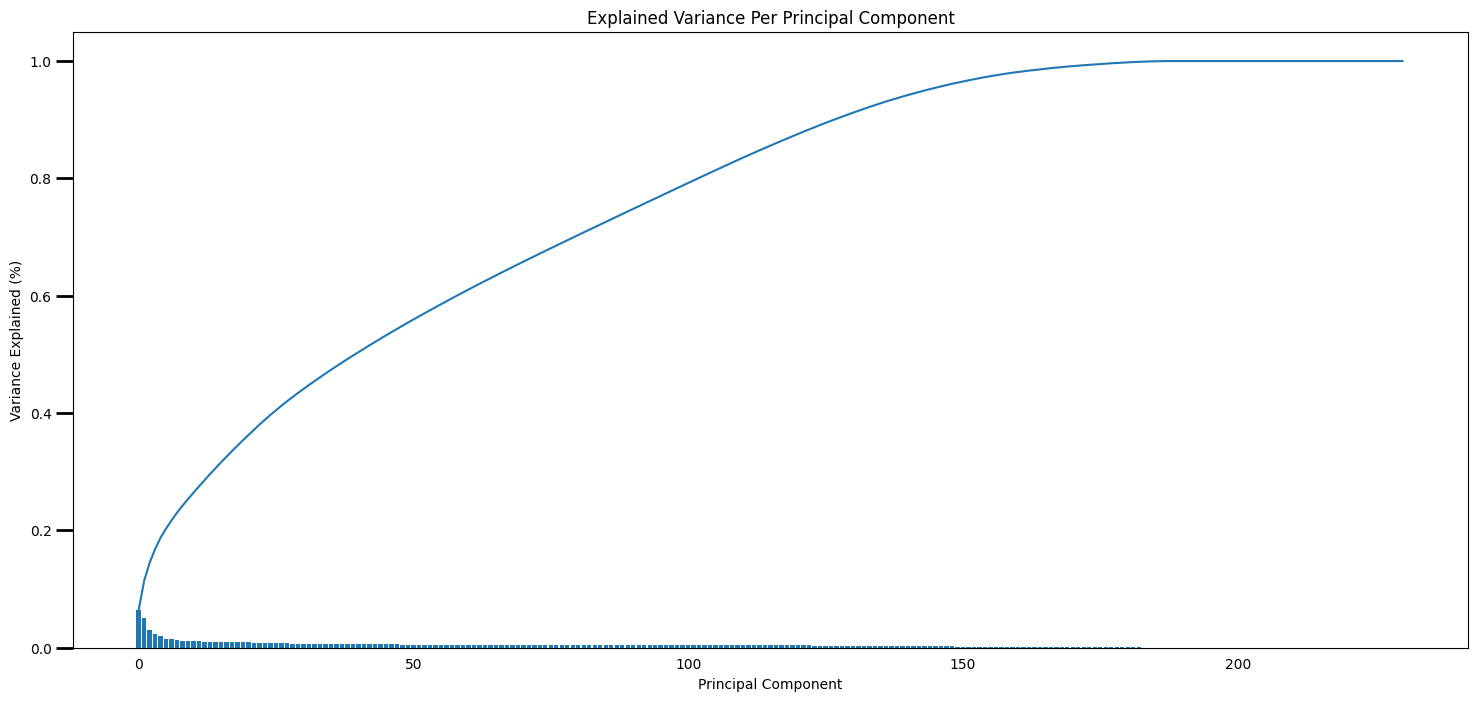

In [50]:
# Investigate the variance accounted for by each principal component.
scene_plot(pca, show_labels=False)

In [51]:
for i in np.arange(10, 121, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))


10 components explain 0.25368055913958526 of variance.
20 components explain 0.35393971329976875 of variance.
30 components explain 0.43428690752532517 of variance.
40 components explain 0.4979748398163625 of variance.
50 components explain 0.5542278372945232 of variance.
60 components explain 0.605527721454661 of variance.
70 components explain 0.6533837163870941 of variance.
80 components explain 0.6990261780825262 of variance.
90 components explain 0.7436614178205321 of variance.
100 components explain 0.7878061486922144 of variance.
110 components explain 0.831217277684091 of variance.
120 components explain 0.8718872556538579 of variance.


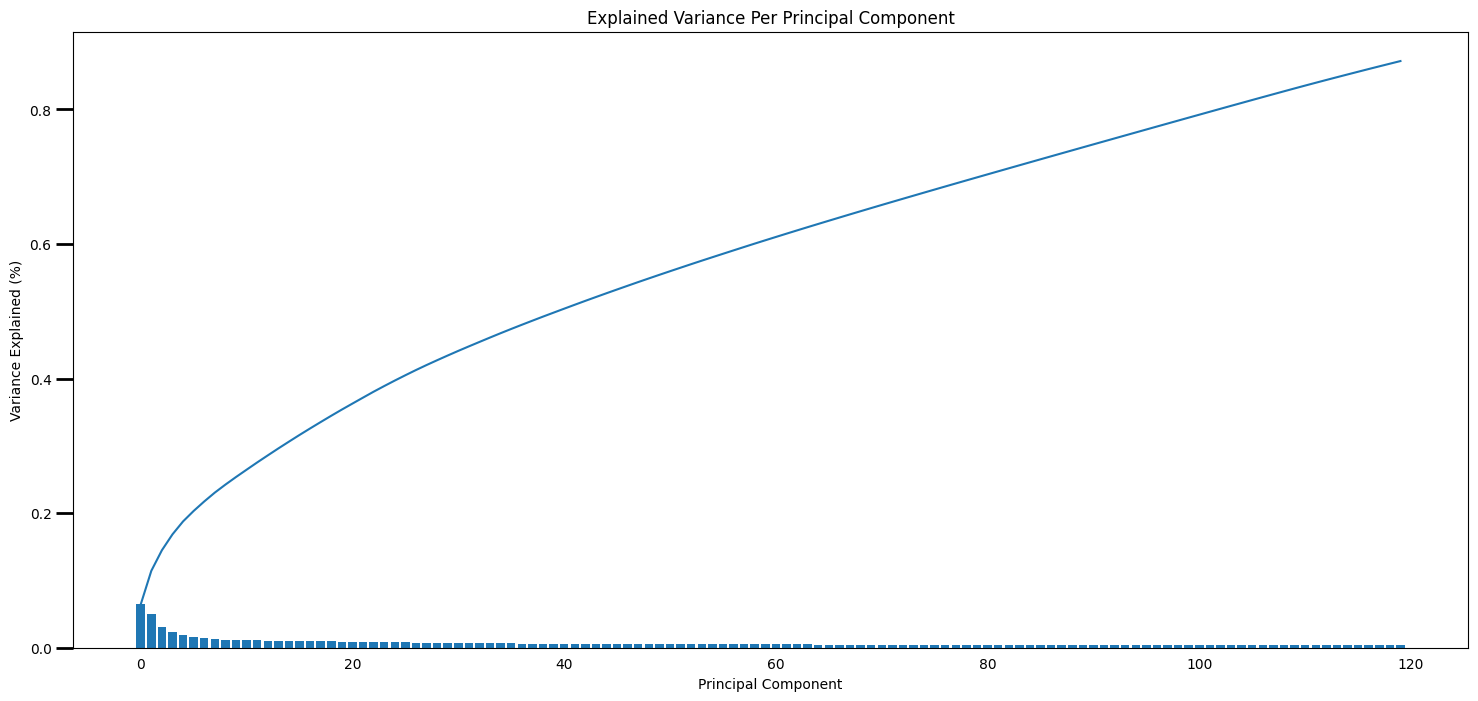

In [52]:
#The data has 228 components in total
scene_plot(pca, components_no=120, show_labels=False)

In [53]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=120)
azdias_pca = pca.fit_transform(azdias_clean_std)

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?

I decided to mantain 120 components from 231 features with explanation of 87%

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

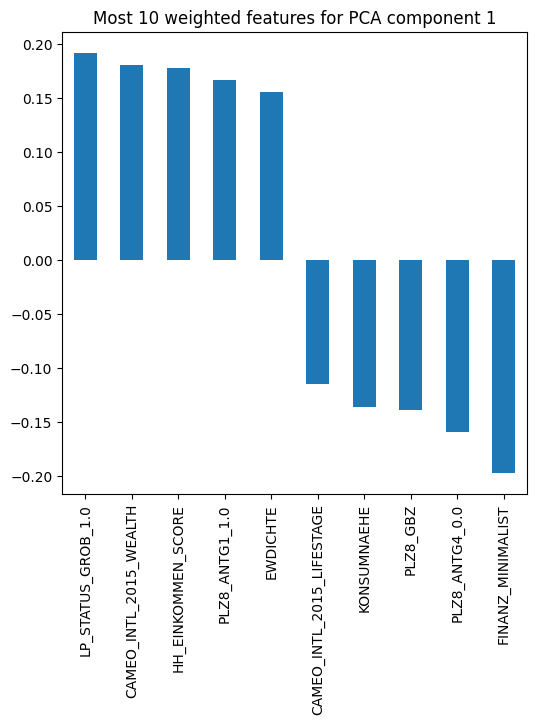

LP_STATUS_GROB_1.0           0.1915
CAMEO_INTL_2015_WEALTH       0.1811
HH_EINKOMMEN_SCORE           0.1776
PLZ8_ANTG1_1.0               0.1667
EWDICHTE                     0.1554
CAMEO_INTL_2015_LIFESTAGE   -0.1151
KONSUMNAEHE                 -0.1358
PLZ8_GBZ                    -0.1386
PLZ8_ANTG4_0.0              -0.1595
FINANZ_MINIMALIST           -0.1975
Name: 0, dtype: float64
LP_STATUS_GROB_1.0           0.1915
CAMEO_INTL_2015_WEALTH       0.1811
HH_EINKOMMEN_SCORE           0.1776
PLZ8_ANTG1_1.0               0.1667
EWDICHTE                     0.1554
CAMEO_INTL_2015_LIFESTAGE   -0.1151
KONSUMNAEHE                 -0.1358
PLZ8_GBZ                    -0.1386
PLZ8_ANTG4_0.0              -0.1595
FINANZ_MINIMALIST           -0.1975
Name: 0, dtype: float64


In [54]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
res = pca_weights(azdias_clean, pca, 1, 5)
print(res)

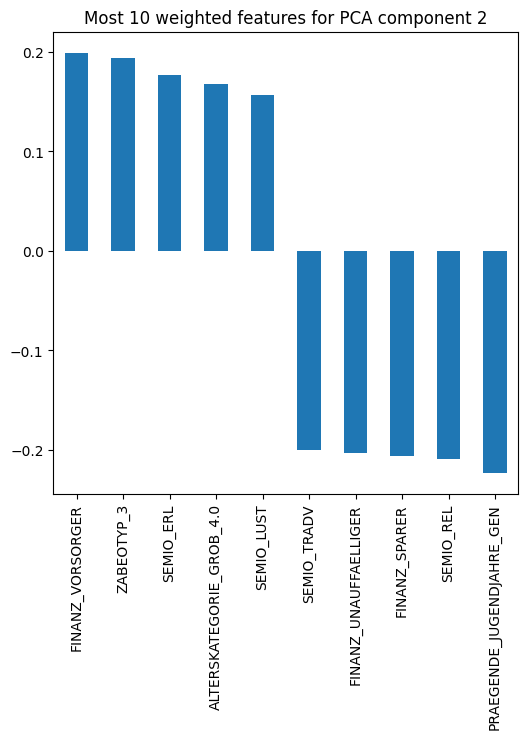

FINANZ_VORSORGER             0.1993
ZABEOTYP_3                   0.1939
SEMIO_ERL                    0.1765
ALTERSKATEGORIE_GROB_4.0     0.1679
SEMIO_LUST                   0.1565
SEMIO_TRADV                 -0.2006
FINANZ_UNAUFFAELLIGER       -0.2035
FINANZ_SPARER               -0.2063
SEMIO_REL                   -0.2090
PRAEGENDE_JUGENDJAHRE_GEN   -0.2228
Name: 1, dtype: float64
FINANZ_VORSORGER             0.1993
ZABEOTYP_3                   0.1939
SEMIO_ERL                    0.1765
ALTERSKATEGORIE_GROB_4.0     0.1679
SEMIO_LUST                   0.1565
SEMIO_TRADV                 -0.2006
FINANZ_UNAUFFAELLIGER       -0.2035
FINANZ_SPARER               -0.2063
SEMIO_REL                   -0.2090
PRAEGENDE_JUGENDJAHRE_GEN   -0.2228
Name: 1, dtype: float64


In [55]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_weights(azdias_clean, pca,2 , 5)
print(res)

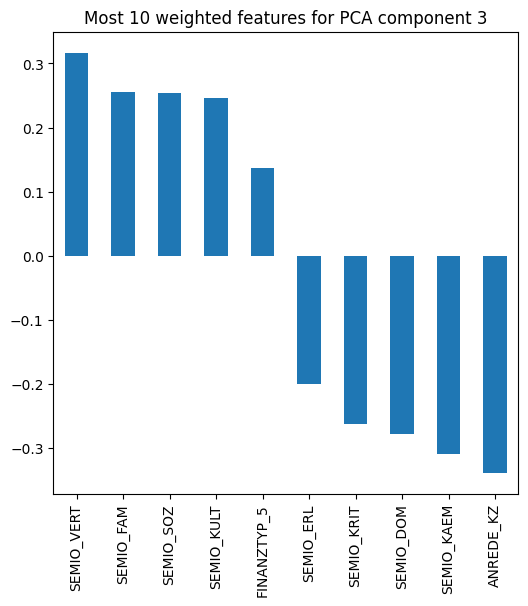

SEMIO_VERT     0.3171
SEMIO_FAM      0.2554
SEMIO_SOZ      0.2535
SEMIO_KULT     0.2456
FINANZTYP_5    0.1363
SEMIO_ERL     -0.1999
SEMIO_KRIT    -0.2624
SEMIO_DOM     -0.2788
SEMIO_KAEM    -0.3089
ANREDE_KZ     -0.3384
Name: 2, dtype: float64
SEMIO_VERT     0.3171
SEMIO_FAM      0.2554
SEMIO_SOZ      0.2535
SEMIO_KULT     0.2456
FINANZTYP_5    0.1363
SEMIO_ERL     -0.1999
SEMIO_KRIT    -0.2624
SEMIO_DOM     -0.2788
SEMIO_KAEM    -0.3089
ANREDE_KZ     -0.3384
Name: 2, dtype: float64


In [56]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

res = pca_weights(azdias_clean, pca, 3, 5)
print(res)

### Discussion 2.3: Interpret Principal Components

Can we interpret positive and negative values from them in a meaningful way?

### General remarks:

The first component  is related to  **social environment and living**. The second one is related to **financial aspects** and the third one is related to **personality** where is divided in the positive and negative attitude.

## Dimension 1

### POSITIVE 


LP_STATUS_GROB_1.0           0.1915 - Social status, rough scale

CAMEO_INTL_2015_WEALTH       0.1811 - Wealthy Households

HH_EINKOMMEN_SCORE           0.1776 - Estimated household net income

#### NEGATIVE

CAMEO_INTL_2015_LIFESTAGE   -0.1151 Life Stage Typology

KONSUMNAEHE                 -0.1358 Distance from building to point of sale (PoS)

PLZ8_GBZ                    -0.1386 Number of buildings within the PLZ8 region



## Dimension 2

####  POSITIVE

FINANZ_VORSORGER             0.1993  - Financial typology, for each dimension: be prepared

ZABEOTYP_3                   0.1939 - Energy consumption typology 3: fair supplied

SEMIO_ERL                    0.1765 Personality typology, for each dimension: ERL: event-oriented


                  



#### NEGATIVE


SEMIO_TRADV                 -0.2037 Personality typology, for each dimension: TRADV: tradional-minded

FINANZ_UNAUFFAELLIGER       -0.2082  Financial typology, UNAUFFAELLIGER: inconspicuous

FINANZ_SPARER               -0.2138  Financial typology, SPARER: money-saver


## Dimension 3

####  POSITIVE

           
SEMIO_VERT    0.3173 - Personality typology, for each dimension: VERT: dreamful

SEMIO_FAM      0.2543  - Personality typology, for each dimension: FAM: family-minded

SEMIO_SOZ      0.2530  - Personality typology, for each dimension: SOZ: socially-minded

#### NEGATIVE


SEMIO_ERL     -0.1987 Personality typology, for each dimension: ERL: event-oriented

SEMIO_KRIT    -0.2606 Personality typology, for each dimension:  critical-minded

SEMIO_DOM     -0.2761  - Personality typology, for each dimension:DOM: dominant-minded






## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [57]:
# Over a number of different cluster counts...


score_list = [] # Sum of Squared Errors
cluster_range = np.arange(1,32,2)

for cluster in cluster_range:
    # run k-means clustering on the data 
    kmeans = KMeans(cluster, n_init=10, random_state=1234).fit(azdias_pca)
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(azdias_pca)) / len(azdias_pca)
    score_list.append(score)
    print('Cluster {} k, score {}'.format(cluster, score))


    
    

    


Cluster 1 k, score 198.0289362331501
Cluster 3 k, score 180.89962402597274
Cluster 5 k, score 174.1363230616459
Cluster 7 k, score 170.39471835468015
Cluster 9 k, score 167.52813112389384
Cluster 11 k, score 165.12642252458477
Cluster 13 k, score 163.2021548131027
Cluster 15 k, score 161.5866243122814
Cluster 17 k, score 159.9886924138947
Cluster 19 k, score 158.81675527939115
Cluster 21 k, score 157.0997380138517
Cluster 23 k, score 155.78100039393047
Cluster 25 k, score 154.15759471706767
Cluster 27 k, score 153.12714229714118
Cluster 29 k, score 151.63041130929238
Cluster 31 k, score 149.5779620908668


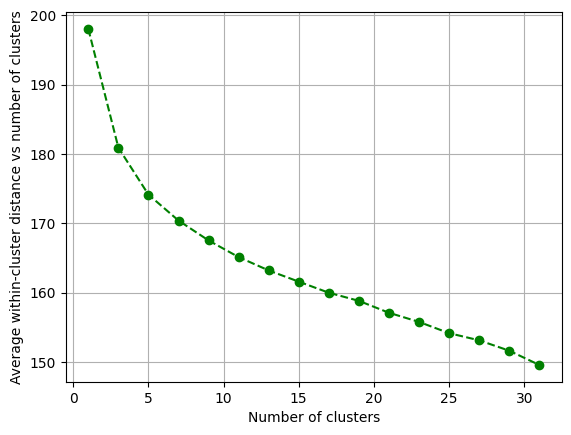

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(cluster_range, score_list, linestyle='--', marker = 'o', color = 'green')
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster distance vs number of clusters')
plt.grid(True)
plt.show()

In [59]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_15 = KMeans(n_clusters = 15, n_init=10, random_state=1234)
kmeans_15.fit(azdias_pca)
azdias_predicted_clusters = kmeans_15.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

Into how many clusters have you decided to segment the population?

#### Answer:

According to the **Elbow Method** , invetigating the graphic of average distance x number of clusters, I found 15 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
df_customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
df_customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [61]:
df_customers.shape

(191652, 85)

In [62]:
df_customers_clean_row = df_customers.iloc[0].copy()
df_customers_clean_row['GEBAEUDETYP']=5.0
df_customers.loc[len(df_customers)] = df_customers_clean_row

In [63]:
# Load in the feature summary file.
df_feat = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

df_customers_clean, df_feat_clean = clean_data(df_customers, df_feat)
# for i in range(len(azdias_clean.columns)):
#     if(azdias_clean.columns[i]!=df_customers_clean.columns[i]):
#         print(azdias_clean.columns[i])
#         break
#df_customers has no 5.0 for GEBAEUDETYP
#df_customers_clean['GEBAEUDETYP_5.0']=  pd.Series(np.zeros((df_customers_clean.shape[0])))

df_customers_clean.shape


0: (191653, 79)


(129815, 231)

In [64]:


# Apply feature scaling to the customers demographics data
customers_clean_std = scaler.transform(df_customers_clean)


In [65]:
#Apply pca - customers
customers_pca = pca.transform(customers_clean_std)

In [66]:
#Clusterring  customers
kmeans_cust = KMeans(n_clusters = 15, n_init=10, random_state=1234).fit(customers_pca)
customer_clusters = kmeans_cust.predict(customers_pca)



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

## Answer:

Overrepresented: groups 0,3,4,8

Underrepresented: groups 5,7,9

Overrepresented is **Conservative person** who live 5 - 10 km to city center

Underrepresented is people linked to **lower middle class**.

### Over

### component 1

ZABEOTYP_4               0.1915  - energy consuption : price driven

LP_STATUS_FEIN_2.0       0.1811  - Social status, fine scale :orientation-seeking low-income earners\\

ARBEIT                   0.1776 - Share of unemployment in community

CAMEO_DEU_2015_9C        0.1667 Afternoon Talk Show

FINANZ_UNAUFFAELLIGER    0.1554  UNAUFFAELLIGER: inconspicuous


### component 2
SEMIO_VERT           0.1993  - VERT: dreamful

INNENSTADT_4.0       0.1939   Distance to city center (downtown) 5 - 10 km to city center

SEMIO_DOM            0.1765 - dominant-minded

CAMEO_DEU_2015_8D    0.1679   Town Seniors

RETOURTYP_BK_S       0.1565    return type

### component 3
SEMIO_KRIT                   0.3171  KRIT: critical-minded

SEMIO_FAM                    0.2554  family-minded

GEBAEUDETYP_RASTER           0.2535  type of building (residential vs. commercial)

HH_EINKOMMEN_SCORE           0.2456  Estimated household net income

VERS_TYP                     0.1363  Insurance typology


### Under

### component 1

BALLRAUM_1.0             0.1915 Distance to nearest urban center less than 10 km

PLZ8_ANTG2_1.0           0.1811 Number of 3-5 family houses in the PLZ8 region, lower share of 3-5 family homes

SEMIO_RAT                0.1776 RAT: rational

CAMEO_DEU_2015_1B        0.1667 1D: Old Nobility

FINANZ_SPARER            0.1554 SPARER: money-saver



### component 2

SEMIO_LUST            0.1993   LUST: sensual-minded

REGIOTYP_5.0          0.1939  lower middle class

PLZ8_HHZ              0.1765  Number of households within the PLZ8 region

CAMEO_DEU_2015_6E     0.1679  6E: Urban Parents

PLZ8_GBZ              0.1565  Number of buildings within the PLZ8 region


### component 3
SEMIO_KULT          0.3171  - KULT: cultural-minded

SEMIO_FAM           0.2554   family-minded

EWDICHTE            0.2535   Density of households per square kilometer

SEMIO_MAT           0.2456  MAT: materialistic

ZABEOTYP_1          0.1363  Energy consumption typology: green


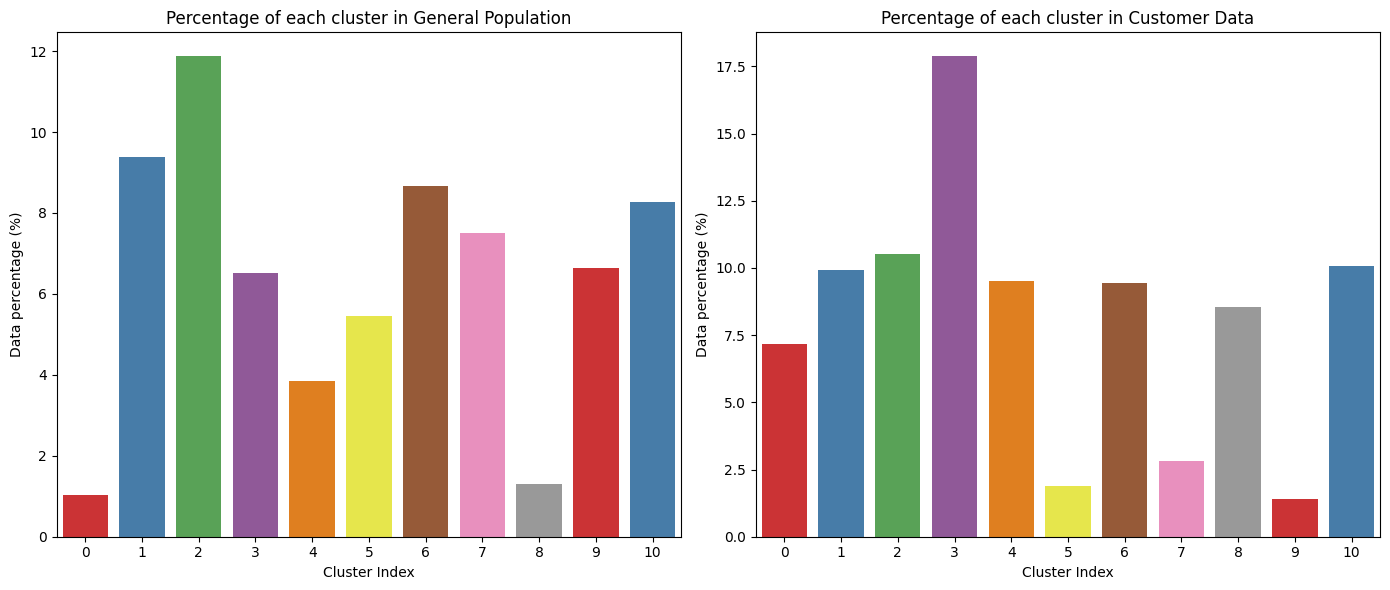

In [67]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_percentage = []
customers_percentage = []

x = [i for i in range(11)]
for i in range(11):
    population_percentage.append((azdias_predicted_clusters == i).sum()*100/len(azdias_predicted_clusters))
    customers_percentage.append((customer_clusters == i).sum()*100/len(customer_clusters))
    
# Convert data to DataFrames
pop_prop = pd.DataFrame({'cluster_id': x, 'population_proportion': population_percentage})
cust_prop = pd.DataFrame({'cluster_id': x, 'customers_proportion': customers_percentage})

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for General Population
sns.barplot(x='cluster_id', y='population_proportion', data=pop_prop, palette='Set1', ax=ax1)
ax1.set_title('Percentage of each cluster in General Population')
ax1.set_xlabel('Cluster Index')
ax1.set_ylabel('Data percentage (%)')

# Plot for Customer Data
sns.barplot(x='cluster_id', y='customers_proportion', data=cust_prop, palette='Set1', ax=ax2)
ax2.set_title('Percentage of each cluster in Customer Data')
ax2.set_xlabel('Cluster Index')
ax2.set_ylabel('Data percentage (%)')

plt.tight_layout()
plt.show()

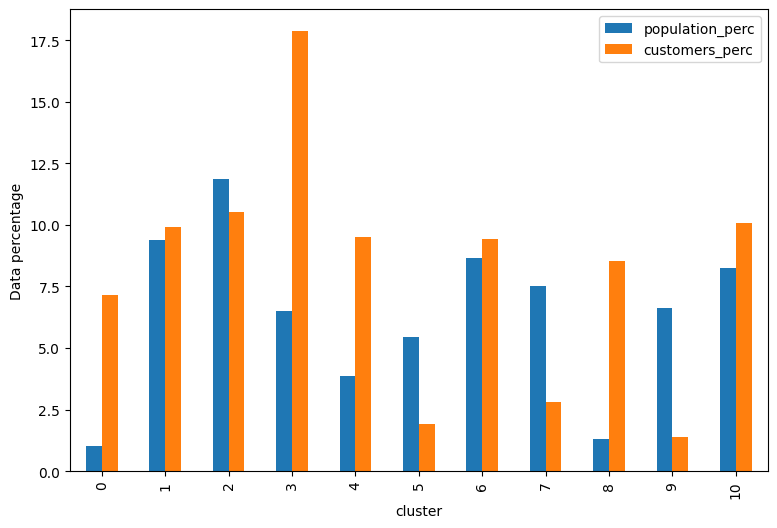

In [68]:
# Combining the plots
df_combined = pd.DataFrame({'cluster' : x, 'population_perc' : population_percentage, 'customers_perc':customers_percentage})
df_combined.plot(x='cluster', y = ['population_perc', 'customers_perc'], kind='bar', figsize=(9,6))
plt.ylabel('Data percentage')
plt.show()

In [76]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#model_15 = kmeans.fit(azdias_pca)

cluster_3 = kmeans_cust.cluster_centers_[3]
pca_3 = pca.inverse_transform(cluster_3)
over_represented = scaler.inverse_transform(pca_3.reshape(1,-1))
over_represented = over_represented.reshape(-1)

over_represented_s = pd.Series(data = over_represented, index=df_customers_clean.columns)
over_represented_s.sort_values(ascending=False,inplace=True)

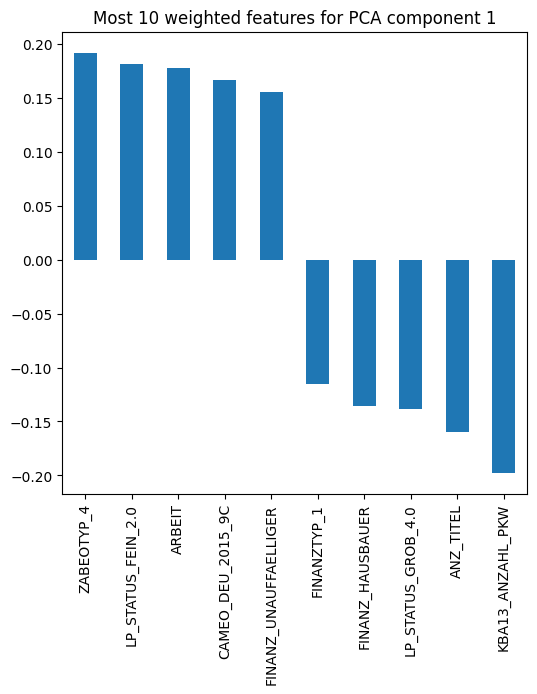

ZABEOTYP_4               0.1915
LP_STATUS_FEIN_2.0       0.1811
ARBEIT                   0.1776
CAMEO_DEU_2015_9C        0.1667
FINANZ_UNAUFFAELLIGER    0.1554
FINANZTYP_1             -0.1151
FINANZ_HAUSBAUER        -0.1358
LP_STATUS_GROB_4.0      -0.1386
ANZ_TITEL               -0.1595
KBA13_ANZAHL_PKW        -0.1975
Name: 0, dtype: float64


In [77]:
res = pca_weights(over_represented_s, pca,1 , 5)

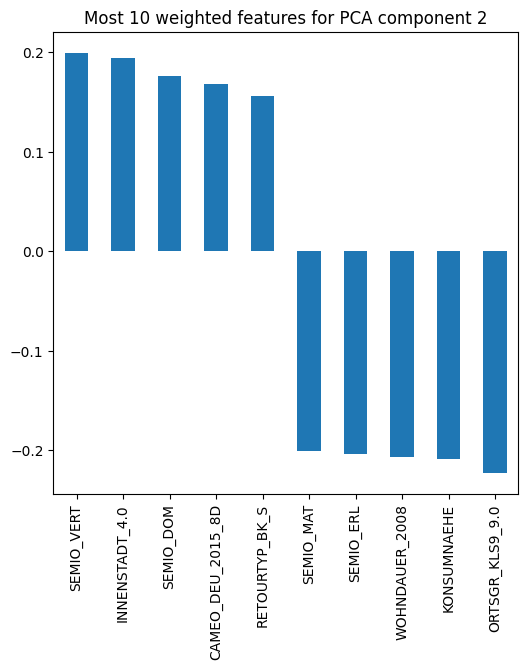

SEMIO_VERT           0.1993
INNENSTADT_4.0       0.1939
SEMIO_DOM            0.1765
CAMEO_DEU_2015_8D    0.1679
RETOURTYP_BK_S       0.1565
SEMIO_MAT           -0.2006
SEMIO_ERL           -0.2035
WOHNDAUER_2008      -0.2063
KONSUMNAEHE         -0.2090
ORTSGR_KLS9_9.0     -0.2228
Name: 1, dtype: float64


In [80]:
res = pca_weights(over_represented_s, pca,2 , 5)

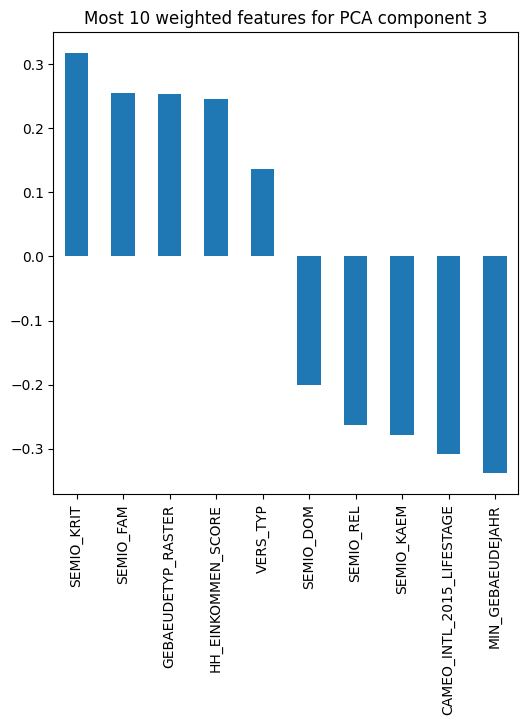

SEMIO_KRIT                   0.3171
SEMIO_FAM                    0.2554
GEBAEUDETYP_RASTER           0.2535
HH_EINKOMMEN_SCORE           0.2456
VERS_TYP                     0.1363
SEMIO_DOM                   -0.1999
SEMIO_REL                   -0.2624
SEMIO_KAEM                  -0.2788
CAMEO_INTL_2015_LIFESTAGE   -0.3089
MIN_GEBAEUDEJAHR            -0.3384
Name: 2, dtype: float64


In [82]:
res = pca_weights(over_represented_s, pca,3 , 5)

In [78]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_7 = kmeans_cust.cluster_centers_[7]
pca_7 = pca.inverse_transform(cluster_7)
under_represented = scaler.inverse_transform(pca_7.reshape(1,-1))
under_represented = under_represented.reshape(-1)

under_represented_s = pd.Series(data = under_represented, index=df_customers_clean.columns)
under_represented_s.sort_values(ascending=False,inplace=True)

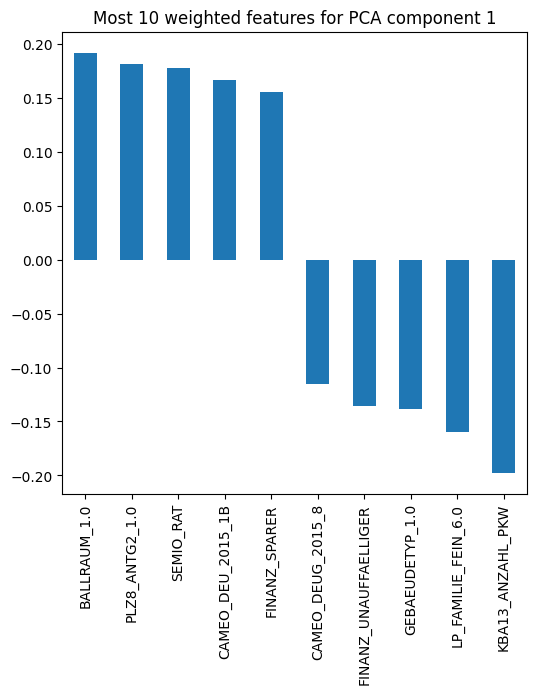

BALLRAUM_1.0             0.1915
PLZ8_ANTG2_1.0           0.1811
SEMIO_RAT                0.1776
CAMEO_DEU_2015_1B        0.1667
FINANZ_SPARER            0.1554
CAMEO_DEUG_2015_8       -0.1151
FINANZ_UNAUFFAELLIGER   -0.1358
GEBAEUDETYP_1.0         -0.1386
LP_FAMILIE_FEIN_6.0     -0.1595
KBA13_ANZAHL_PKW        -0.1975
Name: 0, dtype: float64


In [79]:
res = pca_weights(under_represented_s, pca,1 , 5)

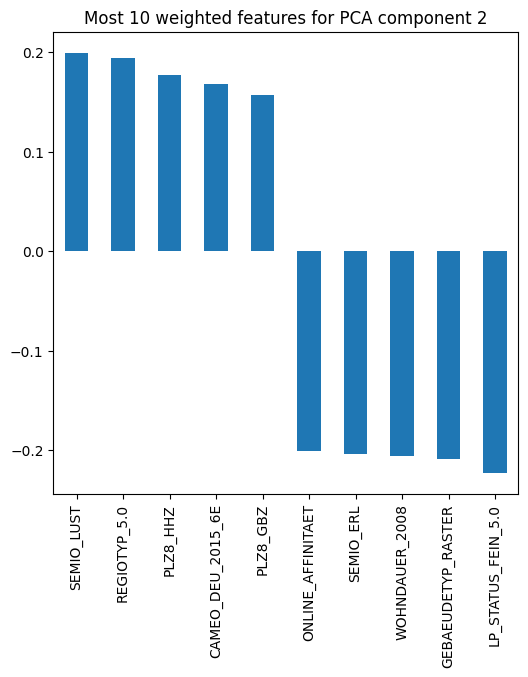

SEMIO_LUST            0.1993
REGIOTYP_5.0          0.1939
PLZ8_HHZ              0.1765
CAMEO_DEU_2015_6E     0.1679
PLZ8_GBZ              0.1565
ONLINE_AFFINITAET    -0.2006
SEMIO_ERL            -0.2035
WOHNDAUER_2008       -0.2063
GEBAEUDETYP_RASTER   -0.2090
LP_STATUS_FEIN_5.0   -0.2228
Name: 1, dtype: float64


In [81]:
res = pca_weights(under_represented_s, pca,2 , 5)

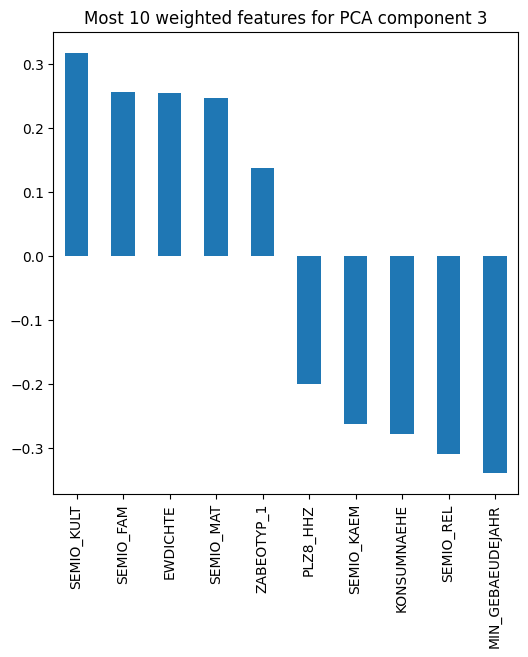

SEMIO_KULT          0.3171
SEMIO_FAM           0.2554
EWDICHTE            0.2535
SEMIO_MAT           0.2456
ZABEOTYP_1          0.1363
PLZ8_HHZ           -0.1999
SEMIO_KAEM         -0.2624
KONSUMNAEHE        -0.2788
SEMIO_REL          -0.3089
MIN_GEBAEUDEJAHR   -0.3384
Name: 2, dtype: float64


In [83]:
res = pca_weights(under_represented_s, pca,3 , 5)

### Discussion 3.3: Compare Customer Data to Demographics Data

 Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

With the founded components is hard to define the segments.
I am facing a challenging task that more features than only categorical at feat-info dataframe need to be transformed to one-hot encoding. 

The company can use the overrepresented clusters as target to mail and underrepresented.  
Overrepresented cluster 3 characterizes a segment of people like  **conservative person** who live near the centerr

Underrepresented cluster 7 characterizes a segment of people in **lower middle class**.


 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [85]:
!jupyter nbconvert --to html /Users/maysa/Documents/code/udacity_unsupervised_project3/Identify_Customer_Segments.ipynb

[NbConvertApp] Converting notebook /Users/maysa/Documents/code/udacity_unsupervised_project3/Identify_Customer_Segments.ipynb to html
[NbConvertApp] Writing 1548845 bytes to /Users/maysa/Documents/code/udacity_unsupervised_project3/Identify_Customer_Segments.html
